Id                   0.0
MSSubClass           0.0
MSZoning             0.0
LotFrontage          0.0
LotArea              0.0
LotShape             0.0
LotConfig            0.0
Neighborhood         0.0
BldgType             0.0
HouseStyle           0.0
OverallQual          0.0
OverallCond          0.0
RoofStyle            0.0
Exterior1st          0.0
Exterior2nd          0.0
MasVnrType           0.0
MasVnrArea           0.0
ExterQual            0.0
Foundation           0.0
BsmtQual             0.0
BsmtExposure         0.0
BsmtFinType1         0.0
BsmtFinSF1           0.0
BsmtUnfSF            0.0
TotalBsmtSF          0.0
HeatingQC            0.0
1stFlrSF             0.0
2ndFlrSF             0.0
GrLivArea            0.0
BsmtFullBath         0.0
FullBath             0.0
HalfBath             0.0
BedroomAbvGr         0.0
KitchenQual          0.0
TotRmsAbvGrd         0.0
Fireplaces           0.0
FireplaceQu          0.0
GarageType           0.0
GarageFinish         0.0
GarageCars           0.0


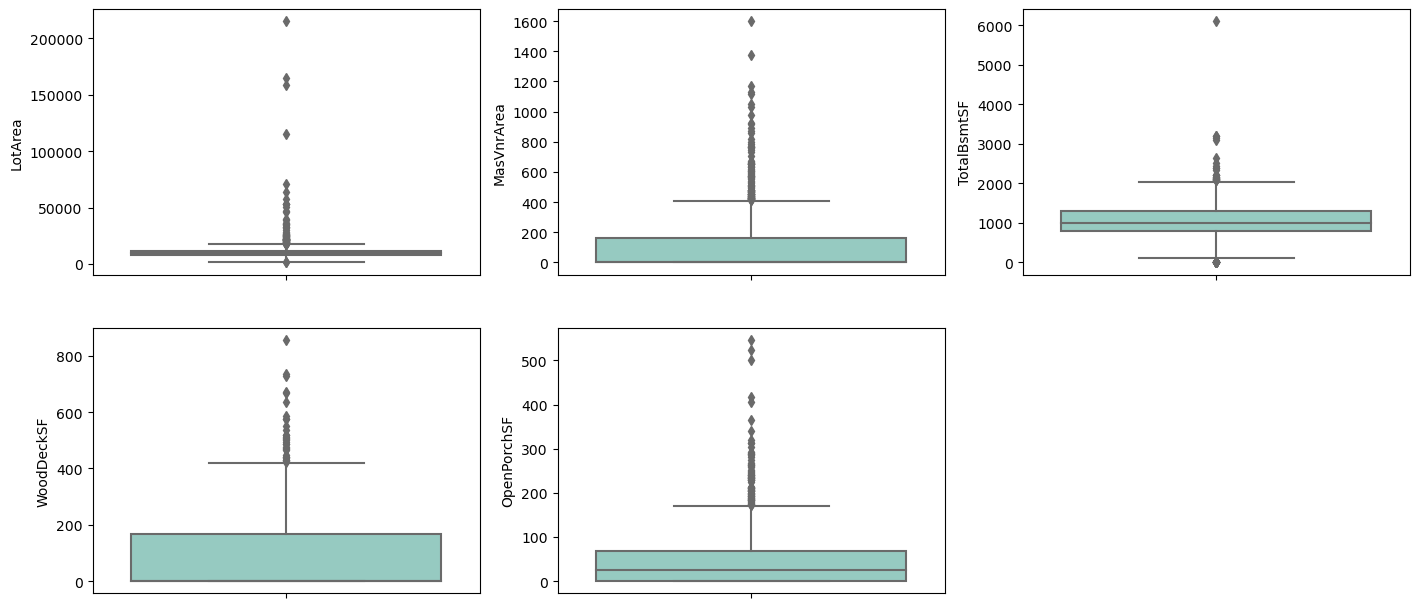

93.01


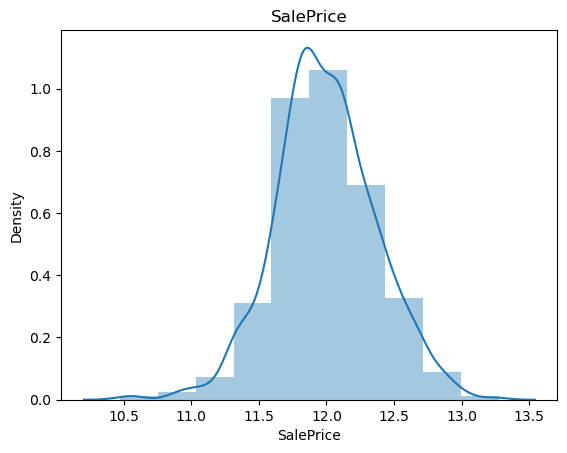

<Figure size 1000x500 with 0 Axes>

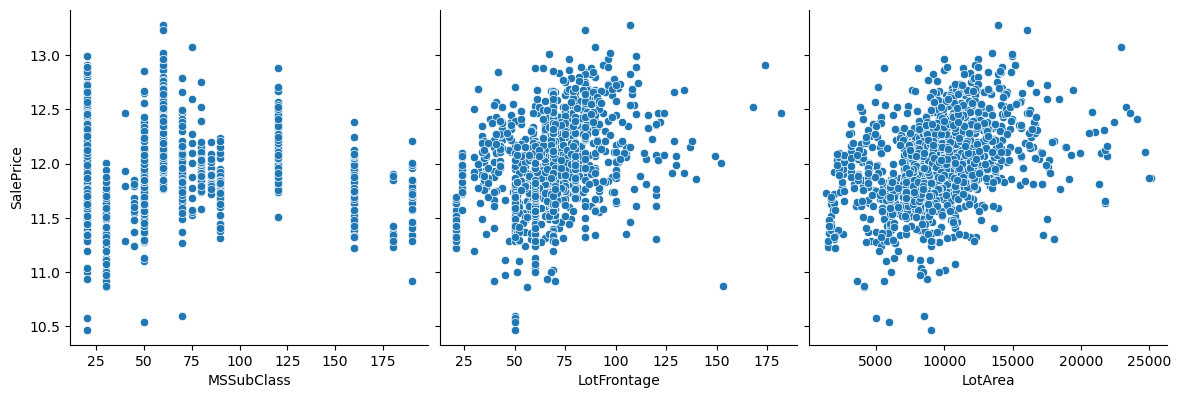

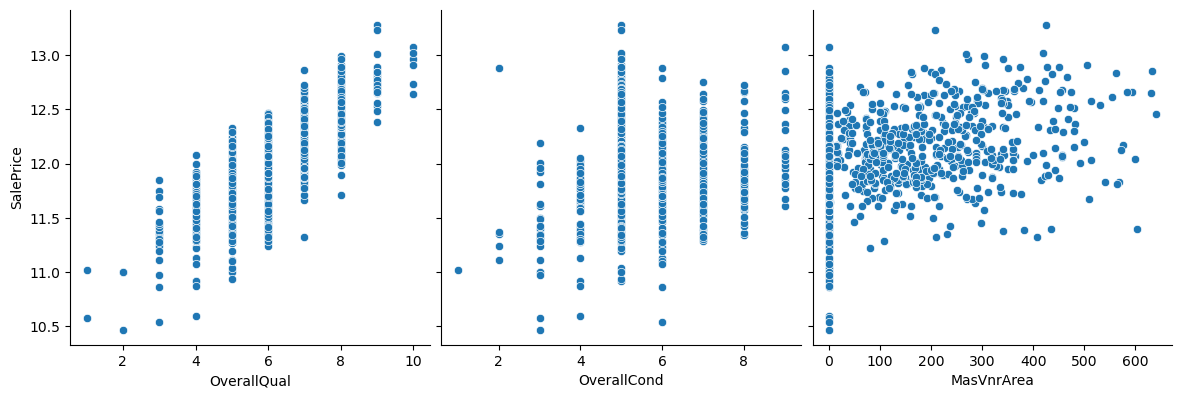

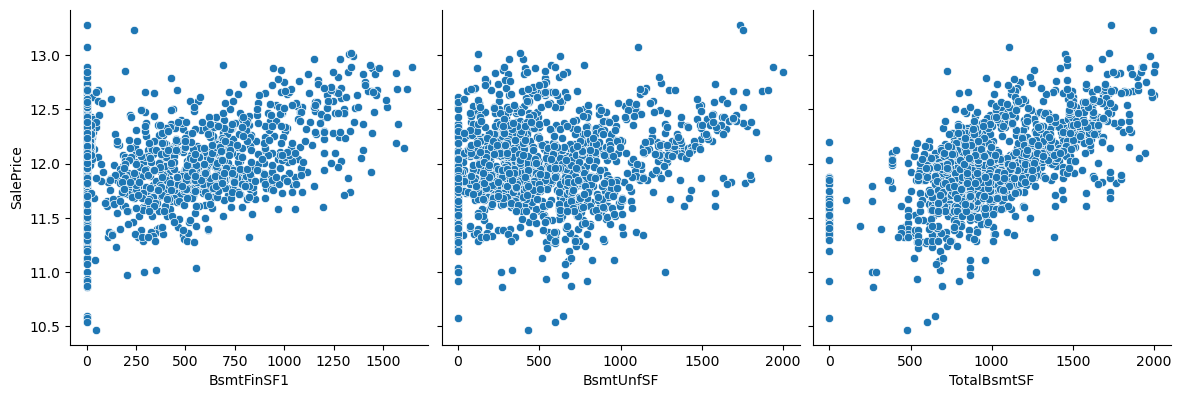

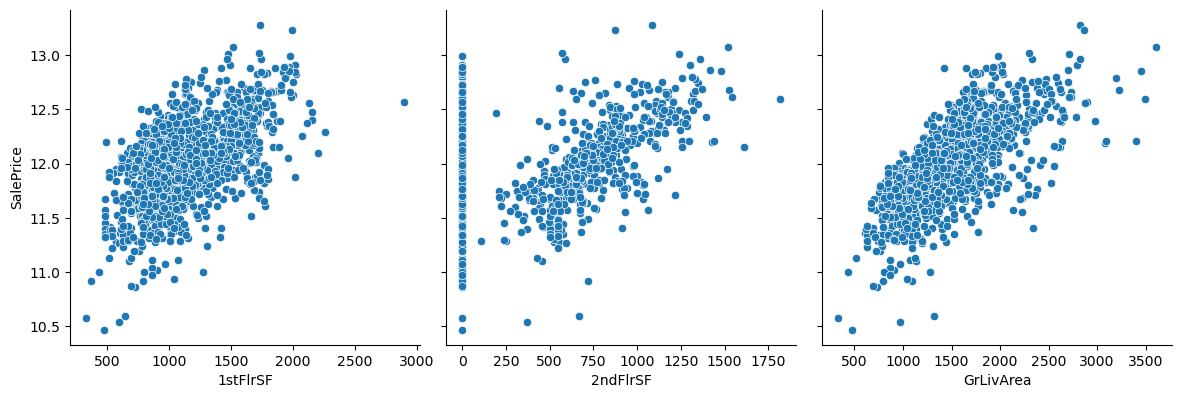

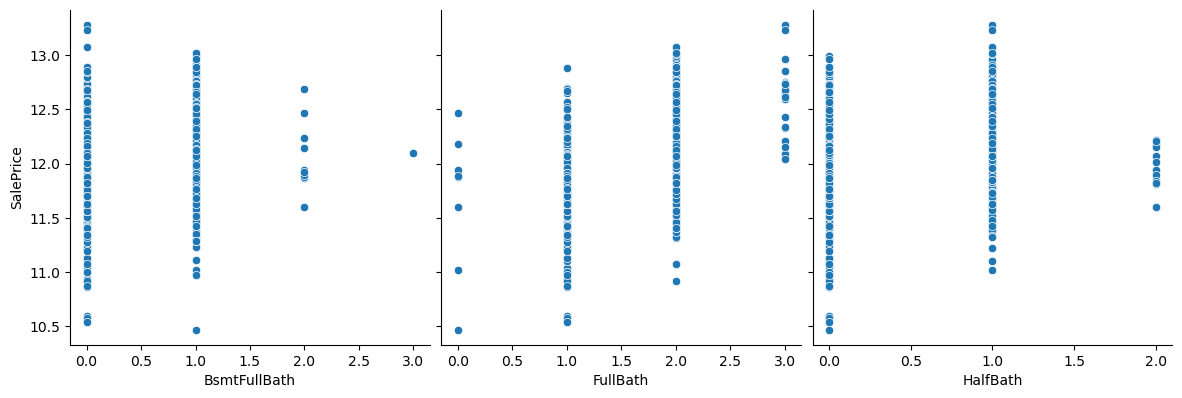

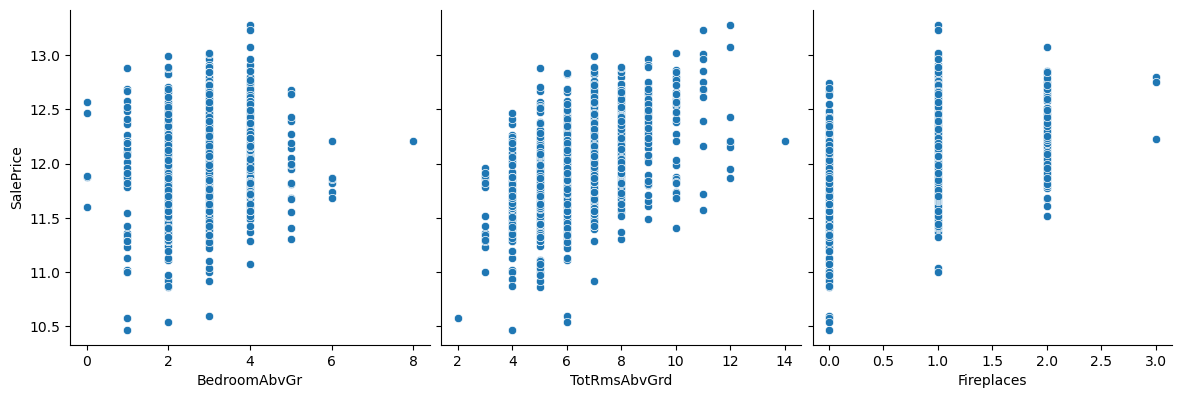

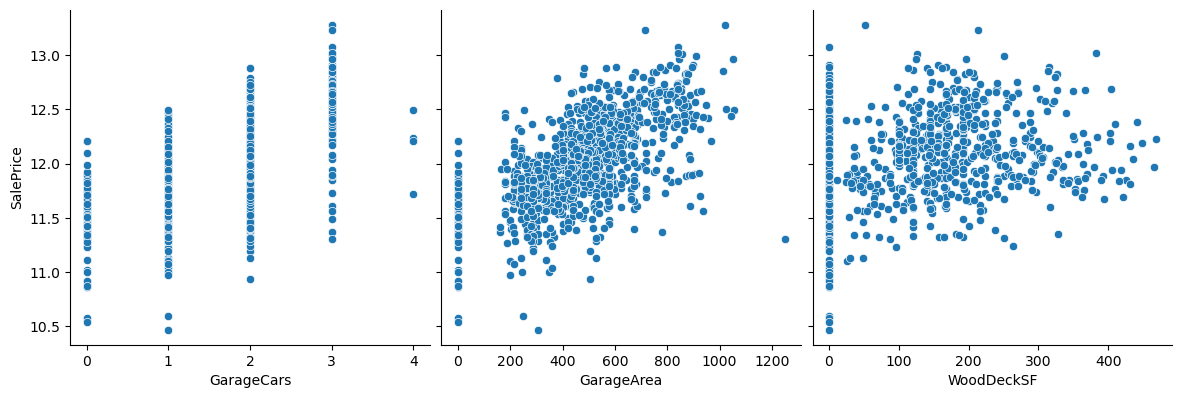

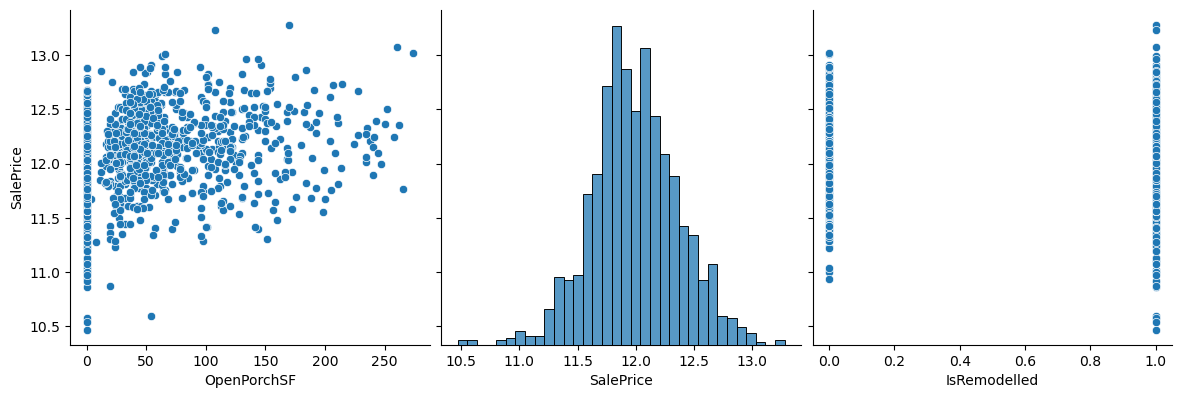

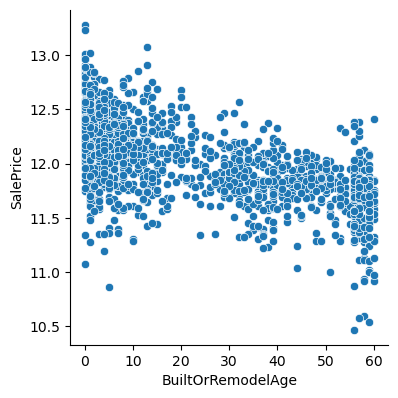

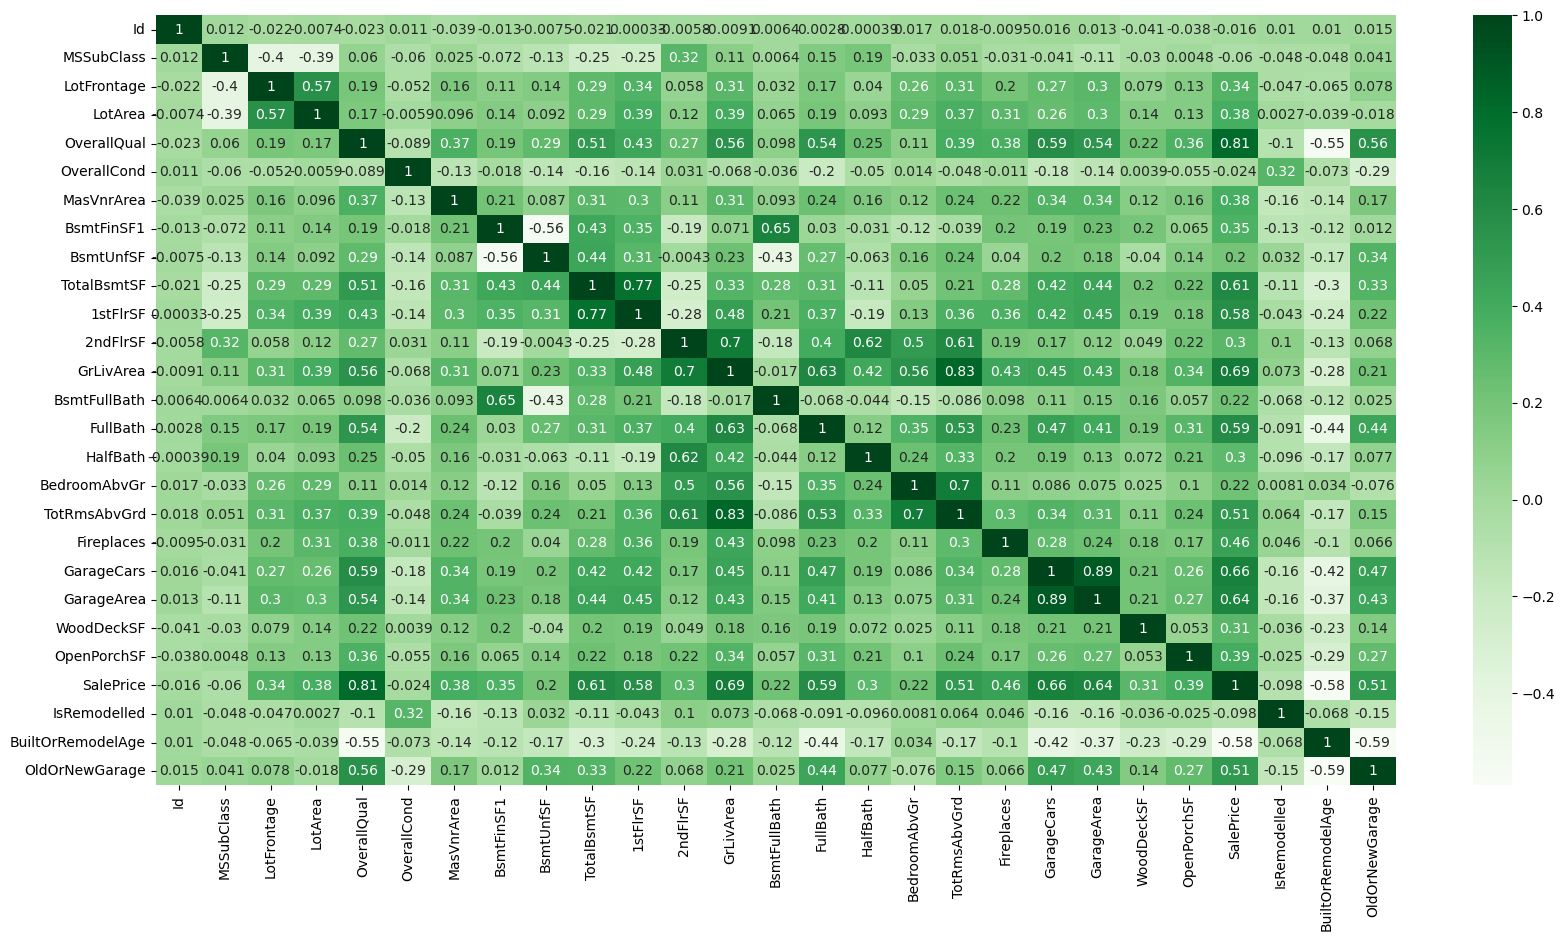

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1358 entries, 0 to 1458
Columns: 112 entries, MSSubClass to GarageType_None
dtypes: float64(3), int64(36), uint8(73)
memory usage: 521.2 KB


ModuleNotFoundError: No module named 'sklearn.cross_validation'

In [3]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')
# Importing all required packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
# Importing dataset

housingInfo = pd.read_csv('train.csv', encoding = 'latin')
housingInfo.head()
# inspect housingInfo dataframe

housingInfo.describe()
#Step 2: Data Cleaning

# check for null values in all categorical columns

housingInfo.select_dtypes(include='object').isnull().sum()[housingInfo.select_dtypes(include='object').isnull().sum()>0]
# Replace NA with None in the following columns below : 

for col in ('Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'Electrical'):
    
    housingInfo[col]=housingInfo[col].fillna('None')
# Drop the following columns that have more than 85% values associated to a specific value

# Method to get the column names that have count of one value more than 85%

def getHighCategoricalValueCounts():
    column = []
    categorical_columns = housingInfo.select_dtypes(include=['object'])
    for col in (categorical_columns):
        if(housingInfo[col].value_counts().max() >= 1241):
            column.append(col)
    return column

columnsToBeRemoved = getHighCategoricalValueCounts()

# Remove the columns with skewed data

housingInfo.drop(columnsToBeRemoved, axis = 1, inplace = True)

housingInfo.head()

#Null value check
housingInfo.select_dtypes(include='object').isnull().sum()[housingInfo.select_dtypes(include='object').isnull().sum()>0]

#Checking null values in numerical values
housingInfo.select_dtypes(include=['int64','float']).isnull().sum()[housingInfo.select_dtypes(include=['int64','float']).isnull()
                                                                  .sum()>0]

# Impute the null values with median values for LotFrontage and MasVnrArea columns

housingInfo['LotFrontage'] = housingInfo['LotFrontage'].replace(np.nan, housingInfo['LotFrontage'].median())
housingInfo['MasVnrArea'] = housingInfo['MasVnrArea'].replace(np.nan, housingInfo['MasVnrArea'].median())
# Setting the null values with 0 for GarageYrBlt for now as we would be handling this column further below

housingInfo['GarageYrBlt']=housingInfo['GarageYrBlt'].fillna(0)
housingInfo['GarageYrBlt'] = housingInfo['GarageYrBlt'].astype(int)
# Create a new column named IsRemodelled - This column would determine whether the house has been remodelled or not based on 
# the difference between remodelled and built years

def checkForRemodel(row):
    if(row['YearBuilt'] == row['YearRemodAdd']):
        return 0
    elif(row['YearBuilt'] < row['YearRemodAdd']):
        return 1
    else:
        return 2
    
housingInfo['IsRemodelled'] = housingInfo.apply(checkForRemodel, axis=1)
housingInfo.head()    
# Create a new column named IsRemodelled - This column would determine whether the house has been remodelled or not based on 
# the difference between remodelled and built years

def checkForRemodel(row):
    if(row['YearBuilt'] == row['YearRemodAdd']):
        return 0
    elif(row['YearBuilt'] < row['YearRemodAdd']):
        return 1
    else:
        return 2
    
housingInfo['IsRemodelled'] = housingInfo.apply(checkForRemodel, axis=1)
housingInfo.head()    

# Create a new column named BuiltOrRemodelledAge and determine the age of the building at the time of selling

def getBuiltOrRemodelAge(row):
    if(row['YearBuilt'] == row['YearRemodAdd']):
        return row['YrSold'] - row['YearBuilt']
    else:
        return row['YrSold'] - row['YearRemodAdd']
       
housingInfo['BuiltOrRemodelAge'] = housingInfo.apply(getBuiltOrRemodelAge, axis=1)
housingInfo.head()  
# Create a new column which would indicate if the Garage is old or new.
# Garage Yr Built less than 2000 will be considered as old (0) else new(1). 
# For GarageYrBuilt , where we have imputed the value as 0 will also be treated as old.

def getGarageConstructionPeriod(row):
    if row == 0:
        return 0
    elif row >= 1900 and row < 2000:        
        return 0
    else:   
        return 1
    
housingInfo['OldOrNewGarage'] = housingInfo['GarageYrBlt'].apply(getGarageConstructionPeriod)
housingInfo.head() 
#Droping columns
housingInfo.drop(['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt'], axis = 1, inplace = True)
# Drop the following columns that have more than 85% values associated to a specific value
# We will also drop MoSold as we will not be using that for further analysis

def getHighNumericalValueCounts():
    column = []
    numerical_columns = housingInfo.select_dtypes(include=['int64', 'float'])
    for col in (numerical_columns):
        if(housingInfo[col].value_counts().max() >= 1241):
            column.append(col)
    return column

columnsToBeRemoved = getHighNumericalValueCounts()
housingInfo.drop(columnsToBeRemoved, axis = 1, inplace = True)

housingInfo.drop(['MoSold'], axis = 1, inplace = True)

housingInfo.head()
# check for percentage of null values in each column

percent_missing = round(100*(housingInfo.isnull().sum()/len(housingInfo.index)), 2)
print(percent_missing)
# Check if there are any duplicate values in the dataset

housingInfo[housingInfo.duplicated(keep=False)]

# Checking outliers at 25%,50%,75%,90%,95% and above

housingInfo.describe(percentiles=[.25,.5,.75,.90,.95,.99])

# Check the outliers in all the numeric columns

plt.figure(figsize=(17, 20))
plt.subplot(5,3,1)
sns.boxplot(y = 'LotArea', palette='Set3', data = housingInfo)
plt.subplot(5,3,2)
sns.boxplot(y = 'MasVnrArea', palette='Set3', data = housingInfo)
plt.subplot(5,3,3)
sns.boxplot(y = 'TotalBsmtSF', palette='Set3', data = housingInfo)
plt.subplot(5,3,4)
sns.boxplot(y = 'WoodDeckSF', palette='Set3', data = housingInfo)
plt.subplot(5,3,5)
sns.boxplot(y = 'OpenPorchSF', palette='Set3', data = housingInfo)
plt.show()

# Removing Outliers

# Removing values beyond 98% for LotArea

nn_quartile_LotArea = housingInfo['LotArea'].quantile(0.98)
housingInfo = housingInfo[housingInfo["LotArea"] < nn_quartile_LotArea]

# Removing values beyond 98% for MasVnrArea

nn_quartile_MasVnrArea = housingInfo['MasVnrArea'].quantile(0.98)
housingInfo = housingInfo[housingInfo["MasVnrArea"] < nn_quartile_MasVnrArea]

# Removing values beyond 99% for TotalBsmtSF

nn_quartile_TotalBsmtSF = housingInfo['TotalBsmtSF'].quantile(0.99)
housingInfo = housingInfo[housingInfo["TotalBsmtSF"] < nn_quartile_TotalBsmtSF]

# Removing values beyond 99% for WoodDeckSF

nn_quartile_WoodDeckSF = housingInfo['WoodDeckSF'].quantile(0.99)
housingInfo = housingInfo[housingInfo["WoodDeckSF"] < nn_quartile_WoodDeckSF]

# Removing values beyond 99% for OpenPorchSF

nn_quartile_OpenPorchSF = housingInfo['OpenPorchSF'].quantile(0.99)
housingInfo = housingInfo[housingInfo["OpenPorchSF"] < nn_quartile_OpenPorchSF]

# Determine the percentage of data retained

num_data = round(100*(len(housingInfo)/1460),2)
print(num_data)

#Step3: Data Visualization
# Visualise the target variable -> SalePrice after transforming the sales price

housingInfo['SalePrice'] = np.log1p(housingInfo['SalePrice'])

plt.title('SalePrice')
sns.distplot(housingInfo['SalePrice'], bins=10)
plt.show()

# Check the numerical values using pairplots

plt.figure(figsize=(10,5))
sns.pairplot(housingInfo, x_vars=['MSSubClass','LotFrontage','LotArea'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(housingInfo, x_vars=['OverallQual', 'OverallCond','MasVnrArea'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(housingInfo, x_vars=['BsmtFinSF1', 'BsmtUnfSF','TotalBsmtSF'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(housingInfo, x_vars=['1stFlrSF','2ndFlrSF', 'GrLivArea'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(housingInfo, x_vars=['BsmtFullBath','FullBath', 'HalfBath'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(housingInfo, x_vars=['BedroomAbvGr','TotRmsAbvGrd', 'Fireplaces'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(housingInfo, x_vars=['GarageCars','GarageArea', 'WoodDeckSF'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(housingInfo, x_vars=['OpenPorchSF','SalePrice', 'IsRemodelled'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(housingInfo, x_vars=['BuiltOrRemodelAge'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
plt.show()

#Observations : - 1stFlrSF, GrLivArea seems to be showing correlation towards right - Rest of the variables are too scattered and hence can be understood during further analysis

# Check the correlation of numerical columns

plt.figure(figsize = (20, 10))
sns.heatmap(housingInfo.corr(), annot = True, cmap="Greens")
plt.show()

# Removing the highly correlated variables

housingInfo.drop(['TotRmsAbvGrd', 'GarageArea'], axis = 1, inplace = True)

#Step4: Data Preparation:

# Since the values of the following fields are ordered list, we shall assign values to them in sequence

# For values which can be ordered, we have given an ordered sequence value
# For values which cannot be ordered, we have categorised them into 0 and 1

housingInfo['d_LotShape'] = housingInfo['LotShape'].map({'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0})
housingInfo['d_ExterQual'] = housingInfo['ExterQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0 })
housingInfo['d_BsmtQual'] = housingInfo['BsmtQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
housingInfo['d_BsmtExposure'] = housingInfo['BsmtExposure'].map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0})
housingInfo['d_BsmtFinType1'] = housingInfo['BsmtFinType1'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 
                                                                 'None': 0})
housingInfo['d_HeatingQC'] = housingInfo['HeatingQC'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
housingInfo['d_KitchenQual'] = housingInfo['KitchenQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
housingInfo['d_FireplaceQu'] = housingInfo['FireplaceQu'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
housingInfo['d_GarageFinish'] = housingInfo['GarageFinish'].map({'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0 })
housingInfo['d_BldgType'] = housingInfo['BldgType'].map({'Twnhs': 5, 'TwnhsE': 4, 'Duplex': 3, '2fmCon': 2, '1Fam': 1, 
                                                                 'None': 0 })
housingInfo['d_HouseStyle'] = housingInfo['HouseStyle'].map({'SLvl': 8, 'SFoyer': 7, '2.5Fin': 6, '2.5Unf': 5, '2Story': 4, 
                                                                 '1.5Fin': 3, '1.5Unf': 2, '1Story': 1, 'None': 0 })
housingInfo['d_Fence'] = housingInfo['Fence'].map({'GdPrv': 4, 'GdWo': 3, 'MnPrv': 2, 'MnWw': 1, 'None': 0 })
housingInfo['d_LotConfig'] = housingInfo['LotConfig'].map({'Inside': 5, 'Corner': 4, 'CulDSac': 3, 'FR2': 2, 'FR3': 1, 
                                                           'None': 0  })
housingInfo['d_MasVnrType'] = housingInfo['MasVnrType'].map({'BrkCmn': 1, 'BrkFace': 1, 'CBlock': 1, 'Stone': 1, 'None': 0 })
housingInfo['d_SaleCondition'] = housingInfo['SaleCondition'].map({'Normal': 1, 'Partial': 1, 'Abnorml': 0, 'Family': 0, 
                                                                   'Alloca': 0, 'AdjLand': 0, 'None': 0})
housingInfo.head()

# drop the old columns from which the new columns were derived
# We can also drop the id column as it will not be used any more

housingInfo = housingInfo.drop(['Id', 'LotShape', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 
                                'KitchenQual', 'FireplaceQu', 'GarageFinish', 'BldgType', 'HouseStyle', 'Fence', 
                                'LotConfig', 'MasVnrType', 'SaleCondition'], axis=1)

housingInfo.head()

# For the following columns create dummies

# Creating dummies for MSZoning

d_MSZoning = pd.get_dummies(housingInfo['MSZoning'], prefix='MSZoning', drop_first = True)
housingInfo = pd.concat([housingInfo, d_MSZoning], axis = 1)

# Creating dummies for Neighborhood

d_Neighborhood = pd.get_dummies(housingInfo['Neighborhood'], prefix='Neighborhood', drop_first = True)
housingInfo = pd.concat([housingInfo, d_Neighborhood], axis = 1)

# Creating dummies for RoofStyle

d_RoofStyle = pd.get_dummies(housingInfo['RoofStyle'], prefix='RoofStyle', drop_first = True)
housingInfo = pd.concat([housingInfo, d_RoofStyle], axis = 1)

# Creating dummies for Exterior1st

d_Exterior1st = pd.get_dummies(housingInfo['Exterior1st'], prefix='Exterior1st', drop_first = True)
housingInfo = pd.concat([housingInfo, d_Exterior1st], axis = 1)

# Creating dummies for Exterior2nd

d_Exterior2nd = pd.get_dummies(housingInfo['Exterior2nd'], prefix='Exterior2nd', drop_first = True)
housingInfo = pd.concat([housingInfo, d_Exterior2nd], axis = 1)

# Creating dummies for Foundation

d_Foundation = pd.get_dummies(housingInfo['Foundation'], prefix='Foundation', drop_first = True)
housingInfo = pd.concat([housingInfo, d_Foundation], axis = 1)

# Creating dummies for GarageType

d_GarageType = pd.get_dummies(housingInfo['GarageType'], prefix='GarageType', drop_first = True)
housingInfo = pd.concat([housingInfo, d_GarageType], axis = 1)

housingInfo.head()

# drop the below columns as we now have new columns derived from these columns

housingInfo = housingInfo.drop(['MSZoning', 'Neighborhood', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'Foundation', 
                                'GarageType'], axis=1)

housingInfo.head()

housingInfo.info()

#Step5: Splitting train and test data
# Putting all feature variable to X

X = housingInfo.drop(['SalePrice'], axis=1)
X.head()

# Putting response variable to y

y = housingInfo['SalePrice']
y.head()

# scaling the features

from sklearn.preprocessing import scale

# storing column names in cols
# scaling (the dataframe is converted to a numpy array)

cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns
# split into train and test

from sklearn.cross_validation import train_test_split

np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size = 0.3, random_state=42)

# Running RFE with the output number of the variable equal to 50

lm = LinearRegression()
lm.fit(X_train, y_train)

# running RFE
rfe = RFE(lm, 50)            
rfe = rfe.fit(X_train, y_train)

# Assign the columns selected by RFE to cols

col = X_train.columns[rfe.support_]

# assign the 50 features selected using RFE to a dataframe and view them

temp_df = pd.DataFrame(list(zip(X_train.columns,rfe.support_,rfe.ranking_)), columns=['Variable', 'rfe_support', 'rfe_ranking'])
temp_df = temp_df.loc[temp_df['rfe_support'] == True]
temp_df.reset_index(drop=True, inplace=True)

temp_df

# Assign the 50 columns to X_train_rfe

X_train_rfe = X_train[col]

# Associate the new 50 columns to X_train and X_test for further analysis

X_train = X_train_rfe[X_train_rfe.columns]
X_test =  X_test[X_train.columns]

# list pf alphas

params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 
                    9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation

folds = 5
ridge_model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
ridge_model_cv.fit(X_train, y_train) 

# display the mean scores

ridge_cv_results = pd.DataFrame(ridge_model_cv.cv_results_)
ridge_cv_results = ridge_cv_results[ridge_cv_results['param_alpha']<=500]
ridge_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

# plotting mean test and train scoes with alpha 

ridge_cv_results['param_alpha'] = ridge_cv_results['param_alpha'].astype('int32')

# plotting

plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_train_score'])
plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()


# get the best estimator for lambda

ridge_model_cv.best_estimator_

# check the coefficient values with lambda = 10

alpha = 10
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

# Check the mean squared error

mean_squared_error(y_test, ridge.predict(X_test))

# Put the Features and coefficienst in a dataframe

ridge_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':ridge.coef_.round(4)})
ridge_df.reset_index(drop=True, inplace=True)
ridge_df

# Assign the Features and their coefficient values to a dictionary which would be used while plotting the bar plot

ridge_coeff_dict = dict(pd.Series(ridge.coef_.round(4), index = X_train.columns))
ridge_coeff_dict

# Do an RFE to minimise the features to 15
X_train_ridge = X_train[ridge_df.Features]

lm = LinearRegression()
lm.fit(X_train_ridge, y_train)

# running RFE
rfe = RFE(lm, 15)            
rfe = rfe.fit(X_train_ridge, y_train)

# Method to get the coefficient values

def find(x):
    return ridge_coeff_dict[x]

# Assign top 10 features to a temp dataframe for further display in the bar plot

temp1_df = pd.DataFrame(list(zip( X_train_ridge.columns, rfe.support_, rfe.ranking_)), columns=['Features', 'rfe_support', 'rfe_ranking'])
temp1_df = temp1_df.loc[temp1_df['rfe_support'] == True]
temp1_df.reset_index(drop=True, inplace=True)

temp1_df['Coefficient'] = temp1_df['Features'].apply(find)
temp1_df = temp1_df.sort_values(by=['Coefficient'], ascending=False)
temp1_df = temp1_df.head(10)
temp1_df

# bar plot to determine the variables that would affect pricing most using ridge regression

plt.figure(figsize=(20,20))
plt.subplot(4,3,1)
sns.barplot(y = 'Features', x='Coefficient', palette='Set1', data = temp1_df)
plt.show()

lasso = Lasso()

# list of alphas

params = {'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01]}

# cross validation

folds = 5
lasso_model_cv = GridSearchCV(estimator = lasso,                         
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model_cv.fit(X_train, y_train) 

# display the mean scores

lasso_cv_results = pd.DataFrame(lasso_model_cv.cv_results_)
lasso_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

# plotting mean test and train scoes with alpha 

lasso_cv_results['param_alpha'] = lasso_cv_results['param_alpha'].astype('float64')

# plotting

plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_train_score'])
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

# get the best estimator for lambda

lasso_model_cv.best_estimator_

# check the coefficient values with lambda = 0.0004

alpha = 0.0004

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 
lasso.coef_

# Check the mean squared error

mean_squared_error(y_test, lasso.predict(X_test))

# Put the shortlisted Features and coefficienst in a dataframe

lasso_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':lasso.coef_.round(4)})
lasso_df = lasso_df[lasso_df['Coefficient'] != 0.00]
lasso_df.reset_index(drop=True, inplace=True)
lasso_df

# Put the Features and Coefficients in dictionary

lasso_coeff_dict = dict(pd.Series(lasso.coef_, index = X_train.columns))
lasso_coeff_dict

# Do an RFE to minimise the features to 15

X_train_lasso = X_train[lasso_df.Features]

lm = LinearRegression()
lm.fit(X_train_lasso, y_train)

# running RFE

rfe = RFE(lm, 15)            
rfe = rfe.fit(X_train_lasso, y_train)

# Method to get the coefficient values

def find(x):
    return lasso_coeff_dict[x]

# Assign top 10 features to a temp dataframe for further display in the bar plot

temp2_df = pd.DataFrame(list(zip( X_train_lasso.columns, rfe.support_, rfe.ranking_)), columns=['Features', 'rfe_support', 'rfe_ranking'])
temp2_df = temp2_df.loc[temp2_df['rfe_support'] == True]
temp2_df.reset_index(drop=True, inplace=True)

temp2_df['Coefficient'] = temp2_df['Features'].apply(find)
temp2_df = temp2_df.sort_values(by=['Coefficient'], ascending=False)
temp2_df = temp2_df.head(10)
temp2_df

# bar plot to determine the variables that would affect pricing most using ridge regression

plt.figure(figsize=(20,20))
plt.subplot(4,3,1)
sns.barplot(y = 'Features', x='Coefficient', palette='Set1', data = temp2_df)
plt.show()



#Conclusion :
#The optimal lambda value in case of Ridge and Lasso is as below:

#Ridge - 10
#Lasso - 0.0004
#The Mean Squared error in case of Ridge and Lasso are:

#Ridge - 0.013743
#Lasso - 0.013556
#The Mean Squared Error of Lasso is slightly lower than that of Ridge

#Also, since Lasso helps in feature reduction (as the coefficient value of one of the feature became 0), Lasso has a better edge over Ridge.

#Hence based on Lasso, the factors that generally affect the price are the Zoning classification, Living area square feet, Overall quality and condition of the house, Foundation type of the house, Number of cars that can be accomodated in the garage, Total basement area in square feet and the Basement finished square feet area

#Therefore, the variables predicted by Lasso in the above bar chart as significant variables for predicting the price of a house.


